# Plotting the true vs. spectroscopic redshift. 

This python script plots (and fits) and spectroscopic richness vs redMaPPer richness. Spectroscopic richnesses are computed by adding the number count of galaxies along the redshift kernel and are assigned different weighting schemes.

In [1]:
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import numpy as np
import tables
import pickle
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import incredible as cr
from scipy.special import erf
from scipy import stats
import scipy.optimize as opt
from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm
import pickle
from astropy import table
from astropy.table import Table, join, unique
from specutils import SpectralRegion
from scipy.interpolate import BSpline, make_interp_spline, UnivariateSpline

In [2]:
from astropy.cosmology import FlatLambdaCDM
from scipy.interpolate import interp1d
import numpy as np
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.cosmology import Planck18
from astropy.cosmology import z_at_value
cosmo = Planck18

## Functions for computing spectroscopic richness and profiles
from projection_functions import *

In [3]:
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt


plot_params = {

'axes.linewidth': 1.25,
'xtick.major.width': 1, 'ytick.major.width': 1,
'xtick.minor.width': 1, 'ytick.minor.width': 1,
'xtick.major.size': 12, 'ytick.major.size': 12,
'xtick.labelsize': 12, 'ytick.labelsize': 12,
'xtick.direction': 'in', 'ytick.direction': 'in',
'xtick.major.pad': 6, 'xtick.minor.pad': 6,
'figure.constrained_layout.use': True,
#'text.usetex': True,
'font.family': 'Serif',
'font.size': 14,
'legend.fontsize': 11
    
}
plt.rcParams.update(plot_params)

## Import Catalogs

* The fluxes are corrected for MW Extinction.
* (!!) Not sure if corrected for K-correction. If not I may have to apply one myself. 

In [4]:
with open('bgs_clus_RM_gal_matched.pickle', 'rb') as handle:
    bgs_matched = pickle.load(handle)

bgs_matched.columns

<TableColumns names=('TARGETID','RA_BGS','DEC_BGS','Z_BGS','WEIGHT','flux_g_dered','flux_r_dered','flux_z_dered','flux_w1_dered','flux_w2_dered','ID','LAMBDA','Z_LAMBDA','R_LAMBDA','Z_SPEC_x','RA_x','DEC_x','MODEL_MAG_R_x','MODEL_MAGERR_R_x','RM_gal_flag','Z_SPEC_y','RA_y','DEC_y','R','P','MODEL_MAG_R_y','MODEL_MAGERR_R_y','geoFrac')>

In [5]:
fcols = ['g','r','z','w1','w2']
for col in fcols:
    #bgs_matched['flux_'+col.lower()+'_dered'] = bgs_matched['FLUX_'+col]/data['MW_TRANSMISSION_'+col]
    bgs_matched['r_dered'] = 22.5 - 2.5*np.log10(bgs_matched['flux_r_dered'])
    bgs_matched['g_dered'] = 22.5 - 2.5*np.log10(bgs_matched['flux_g_dered'])
    bgs_matched['gmr'] = bgs_matched['g_dered']-bgs_matched['r_dered']

In [6]:
#binGap = 1e-5
wide_bin_1 = np.linspace(-0.1,-0.005,21, endpoint=False)
small_bin = np.linspace(-0.005,0.005,21, endpoint=False)
micro_bin = np.linspace(-0.005,0.005,31)
wide_bin_2 = np.linspace(0.005,0.1,21, endpoint=False)


binBoundaries = np.hstack((wide_bin_1, small_bin))
binBoundaries = np.hstack((binBoundaries, wide_bin_2))
binCent = np.asarray([(binBoundaries[i] + binBoundaries[i+1])/2 for i in range(len(binBoundaries)-1)])
binCent_micro = np.asarray([(micro_bin[i] + micro_bin[i+1])/2 for i in range(len(micro_bin)-1)])
bin_width = np.asarray([binBoundaries[i+1]-binBoundaries[i] for i in range(len(binBoundaries[:-1]))])

## None overlapping bins
assert len(set(binCent)) == len(binCent), "Overlapping bins"
assert len(set(binBoundaries)) == len(binBoundaries), "Overlapping bins"

## Binning

In [7]:
#Bin by richness
lmda_bins = [[20,22],[22,25],[25,30],[30,40],[50,200]] #upper limit must match lower limit of next bin
## Bin by redshift
z_bins = [[0.1,0.2],[0.2,0.3],[0.3,0.4]]

lmda_bin_edges = np.logspace(np.log10(20), np.log10(100),11)
lmda_bins = [[lmda_bin_edges[i], lmda_bin_edges[i+1]] for i in range(len(lmda_bin_edges)-1)]

##Create an absolute magnitude column
cosmo = Planck18
h = 0.67
M_r = bgs_matched['r_dered']-cosmo.distmod(bgs_matched['Z_BGS']).value - 5*np.log10(h)
bgs_matched['M_r'] = M_r ##comoving M with h-scaling

##Cuts
bgs_matched = bgs_matched[np.where(bgs_matched['r_dered'] < 19.5)]
#bgs_matched = bgs_matched[np.where(bgs_matched['Z_BGS']< 0.3)]
#bgs_matched = bgs_matched[np.where(bgs_matched['M_r'] < 22)]
#bgs_matched = bgs_matched[np.where(bgs_matched['LAMBDA'] > 100)]

In [8]:
#Assigning spectrospic richnesses to individual cluster. 

from scipy.stats import gaussian_kde
import matplotlib.colors as colors

rmTable = unique(bgs_matched, keys='ID')
ID_list, lambda_tot_list, lambda_true_list  = calc_specRichness_individual(binBoundaries, binCent, bgs_matched)
lambda_rm = [rm_lambda for i, rm_lambda in enumerate(rmTable['LAMBDA']) if rmTable['ID'][i] in ID_list] 
rm_id = [rmTable['ID'][i] for i, rm_lambda in enumerate(rmTable['LAMBDA']) if rmTable['ID'][i] in ID_list] 
ind = [i for i, rm_lambda in enumerate(rmTable['LAMBDA']) if rmTable['ID'][i] in ID_list]

lambda_tot_list = np.asarray(lambda_tot_list)
lambda_true_list = np.asarray(lambda_true_list)
lambda_rm = np.asarray(lambda_rm)

##Filtering out the clusters with no spectrospic richness information and assigning spectroscopic information
rmTable = rmTable[ind]
rmTable['lambda_true'] = lambda_true_list
rmTable['lambda_tot'] = lambda_tot_list
rm_df = rmTable.to_pandas()

/global/homes/z/zzhang13/.conda/envs/myEnv_v39/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/global/homes/z/zzhang13/.conda/envs/myEnv_v39/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


## Plotting

### Plotting individual

In [9]:
nbins=300
k = gaussian_kde([lambda_rm, lambda_true_list,])

#xi, yi = np.mgrid[
#   0:500:nbins*1j,
#   20:300:nbins*1j]

xi, yi = np.mgrid[
    np.min(lambda_rm):np.max(lambda_rm):nbins*1j,
    lambda_true_list.min():lambda_true_list.max():nbins*1j]

zi = k(np.vstack([
   xi.flatten(),
   yi.flatten()
])).reshape(xi.shape)

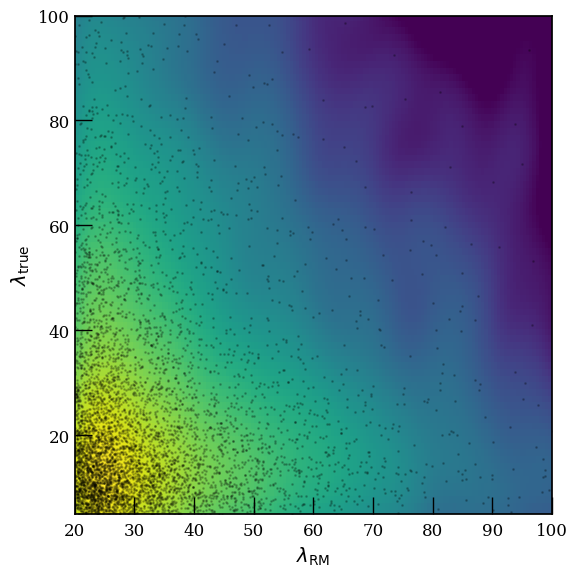

In [10]:
fig, ax = plt.subplots(1, figsize=(6,6), sharex='all', sharey='all', tight_layout=True)
pcm =ax.pcolormesh(xi, yi, zi, norm=colors.LogNorm(1e-6,zi.max()))
ax.scatter(lambda_rm, lambda_true_list, s=1, alpha=0.2, color='black')
#ax.scatter(lambda_true_list, lambda_rm)
plt.ylabel(r'$\lambda_{\rm true}$', )
plt.xlabel(r'$\lambda_{\rm RM}$')
#plt.suptitle(r'$z < 0.2$')
plt.xlim([20,100]); plt.ylim([5,100])
#fig.colorbar(pcm, ax=ax, extend='max')
plt.show()

### Conditonal probability and summary statistics.
See if you can plot the conditional lambda-lambda relation and Q-Q plot with summary statistics. 

In [11]:
###For RM in bins plot the lambda_true distribution. Then find the best Gaussian fit.
lmda_bins = [20,22,25,30,40,60,200]

### What is the number of clusters in each bin. 

for i in range(len(lmda_bins)-1):
    cut = np.where((lambda_rm > lmda_bins[i]) & (lambda_rm < lmda_bins[i+1]))
    lambda_rm_bin = lambda_rm[cut]
    print("Number of clusters in bin: {:d}-{:d}, ".format(lmda_bins[i],lmda_bins[i+1]), len(lambda_rm_bin))

Number of clusters in bin: 20-22,  870
Number of clusters in bin: 22-25,  1337
Number of clusters in bin: 25-30,  1486
Number of clusters in bin: 30-40,  1572
Number of clusters in bin: 40-60,  1000
Number of clusters in bin: 60-200,  380


In [12]:
## Group df by lmba_bins
# Create a binned column
rm_df['lmda_bin'] = pd.cut(rm_df['LAMBDA'], lmda_bins)

In [13]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def log_prior(theta):
    A, mu, sigma = theta
    if 0 < A < 10 and -10 < mu < 10 and 0.1 < sigma < 10:
        return 0.0  # uniform prior (log(1))
    return -np.inf  # log(0), impossible

def log_likelihood(theta, x, y, yerr):
    A, mu, sigma = theta
    model = gaussian(x, A, mu, sigma)
    return -0.5 * np.sum(((y - model) / yerr) ** 2)

def log_posterior(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

def run_fit(x, y, yerr, log_posterior, ndim, nwalkers, initial, length=2000, discard=500, verbose=False):
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, yerr))
    sampler.run_mcmc(p0, length, progress=verbose)
    samples = sampler.get_chain(discard=discard, flat=True)
    return sampler, samples

100%|██████████| 2000/2000 [00:01<00:00, 1204.68it/s]


30.342561000179607 18 0.03424623173529173


100%|██████████| 2000/2000 [00:01<00:00, 1158.39it/s]


32.37406814545208 18 0.019847209053719728


100%|██████████| 2000/2000 [00:01<00:00, 1181.60it/s]


85.91866112992557 18 7.740663665600778e-11


100%|██████████| 2000/2000 [00:01<00:00, 1192.20it/s]


63.221211539675664 18 6.108798537018956e-07


100%|██████████| 2000/2000 [00:01<00:00, 1150.96it/s]


73.06149943014566 18 1.3616773486546663e-08


100%|██████████| 2000/2000 [00:01<00:00, 1194.54it/s]


33.204300525743825 18 0.01576497956664069


100%|██████████| 2000/2000 [00:01<00:00, 1184.89it/s]


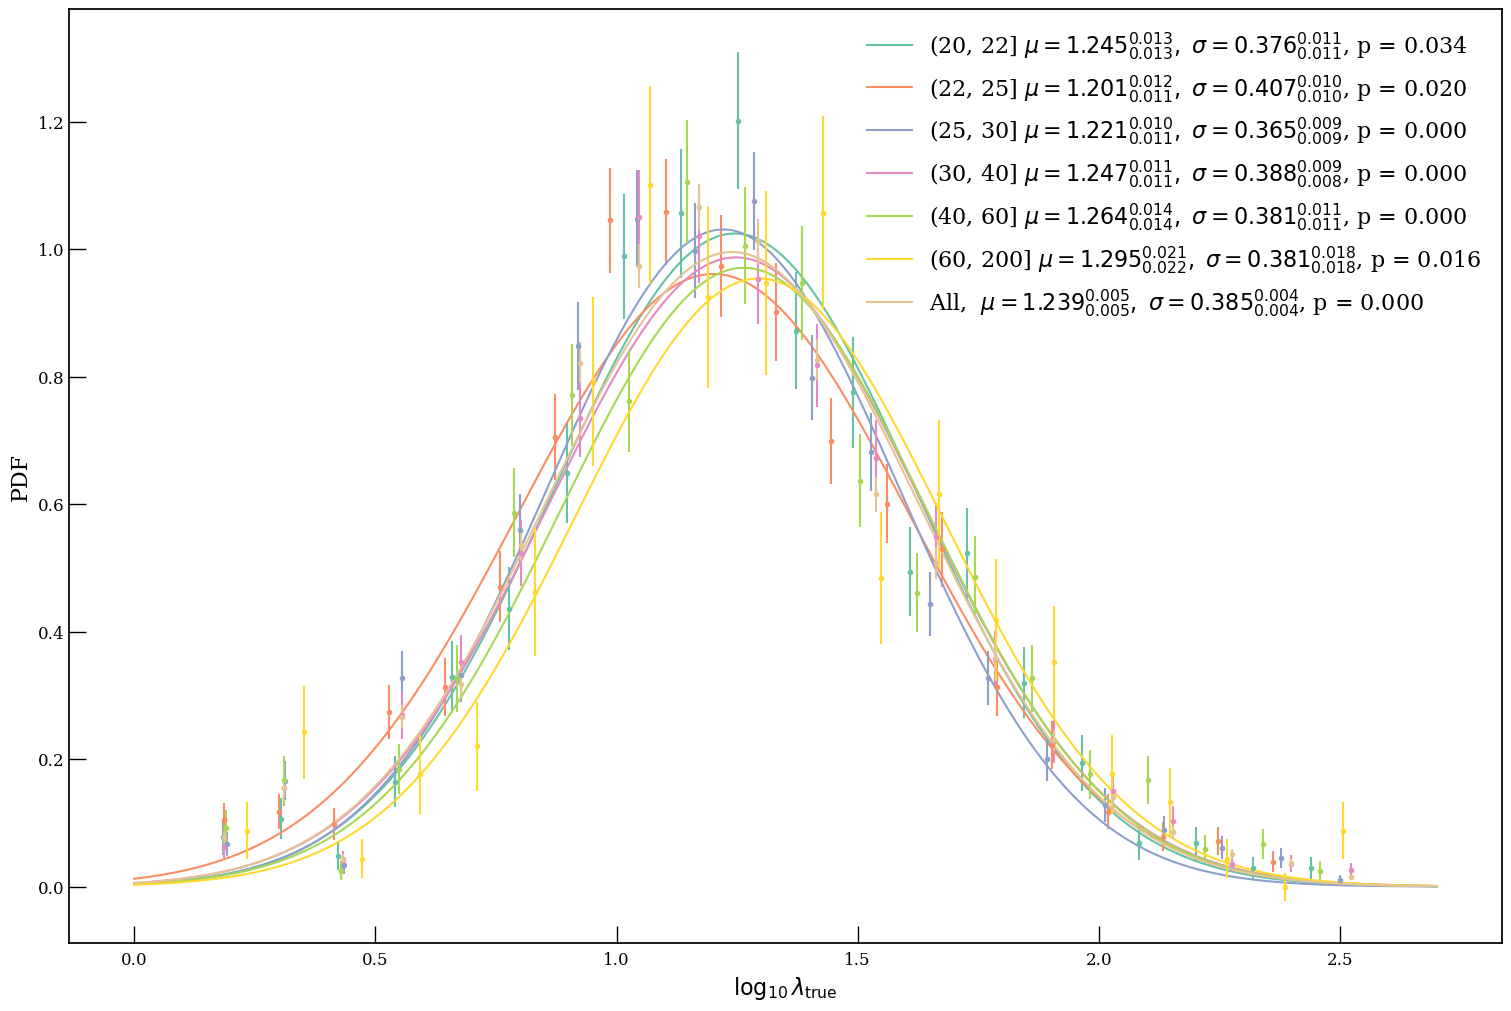

In [14]:
## Gaussian fit

from scipy.stats import chi2
nbins=20
xline = np.linspace(0,2.7, 1000)
ndim, nwalkers = 3, 32
initial = np.array([1, 1.1, 0.3])  # Initial guess
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)
length = 2000
discard = 500
verbose=True
fontsize=16
plt.figure(figsize=(15,10))

##Todo: Include 1-sigma errors on best_fit

## Plot diagnositc plots for spectroscopic richnesses
cmap = plt.get_cmap('Set2')
color_ind = 0
for key, group in rm_df.groupby('lmda_bin', observed=True):
    ###Binned data
    y, lmda_binEdges = np.histogram(np.log10(group['lambda_true']), bins=nbins, density=True)
    x = [(lmda_binEdges[i] +lmda_binEdges[i+1])/2 for i in range(len(lmda_binEdges)-1)]
    bin_width = np.asarray([(lmda_binEdges[i+1] - lmda_binEdges[i]) for i in range(len(lmda_binEdges)-1)])
    totNum = len(group)
    numCount = y*bin_width*totNum
    yerr = np.sqrt(numCount)/(bin_width*totNum)
    null_ind = np.where(y==0)[0]
    yerr[null_ind] = 1/(bin_width[null_ind]*totNum)

    ##Include the Gaussian fits here. 
    sampler, samples = run_fit(x, y, yerr, log_posterior, ndim, nwalkers, initial, length=length, discard=discard, verbose=verbose)

    #best_fit = samples[np.argmax(sampler.get_log_prob(flat=True))]
    #best_fit_label = str(key) + r" $\mu = ${:.2f}, $\sigma = ${:.2f}".format(best_fit[1], best_fit[2])

    best_fit = np.percentile(samples, 50, axis=0)
    lower = np.percentile(samples, 16, axis=0)     # Lower 1-sigma
    upper = np.percentile(samples, 84, axis=0)     # Upper 1-sigma
    # 1-sigma errors:
    errs_minus = best_fit - lower
    errs_plus  = upper - best_fit

    ##Chi-squared p-values
    chi_squared = np.sum(((y - gaussian(x, *best_fit)) ** 2) / (yerr ** 2))
    dof = len(y) - 2  # For a single parameter model, dof = n - 1
    p_value = 1.0 - chi2.cdf(chi_squared, dof)
    print(chi_squared, dof, p_value)

    best_fit_label = str(key) + \
        r" $\mu = $" + f"${best_fit[1]:.3f}^{{{errs_plus[1]:.3f}}}_{{{errs_minus[1]:.3f}}}, $" +  \
        r" $\sigma = $" + f"${best_fit[2]:.3f}^{{{errs_plus[2]:.3f}}}_{{{errs_minus[2]:.3f}}}$" + \
        r', p = ' + f"{p_value:.3f}"

    ##Plotting
    plt.errorbar(x, y, yerr=yerr, fmt=".", color=cmap(color_ind))
    plt.plot(xline, gaussian(xline, *best_fit), label=best_fit_label, color=cmap(color_ind))
    color_ind += 1


##For all
y, lmda_binEdges = np.histogram(np.log10(rm_df['lambda_true']), bins=nbins, density=True)
x = [(lmda_binEdges[i] +lmda_binEdges[i+1])/2 for i in range(len(lmda_binEdges)-1)]
bin_width = np.asarray([(lmda_binEdges[i+1] - lmda_binEdges[i]) for i in range(len(lmda_binEdges)-1)])
totNum = len(rm_df)
numCount = y*bin_width*totNum
yerr = np.sqrt(numCount)/(bin_width*totNum)
null_ind = np.where(y==0)[0]
yerr[null_ind] = 1/(bin_width[null_ind]*totNum)

sampler, samples = run_fit(x, y, yerr, log_posterior, ndim, nwalkers, initial, length=length, discard=discard, verbose=verbose)

#best_fit = samples[np.argmax(sampler.get_log_prob(flat=True))]
best_fit = np.percentile(samples, 50, axis=0)
lower = np.percentile(samples, 16, axis=0)     # Lower 1-sigma
upper = np.percentile(samples, 84, axis=0)     # Upper 1-sigma
# 1-sigma errors:
errs_minus = best_fit - lower
errs_plus  = upper - best_fit
    
##Chi-squared p-values
chi_squared = np.sum(((y - gaussian(x, *best_fit)) ** 2) / (yerr ** 2))
# Compute the degrees of freedom (number of data points minus the number of parameters in the model)
dof = len(y) - 3
# Compute the p-value from the Chi-squared statistic and degrees of freedom
p_value = 1.0 - chi2.cdf(chi_squared, dof)


best_fit_label = "All, " + \
        r" $\mu = $" + f"${best_fit[1]:.3f}^{{{errs_plus[1]:.3f}}}_{{{errs_minus[1]:.3f}}}, $" +  \
        r" $\sigma = $" + f"${best_fit[2]:.3f}^{{{errs_plus[2]:.3f}}}_{{{errs_minus[2]:.3f}}}$" + \
        r', p = ' + f"{p_value:.3f}"


plt.errorbar(x, y, yerr=yerr, fmt=".", color=cmap(color_ind))
plt.plot(xline, gaussian(xline, *best_fit), label=best_fit_label, color=cmap(color_ind))

##Plotting params
plt.xlabel(r'$\log_{10}{\lambda_{\rm true}}$', fontsize=fontsize)
plt.ylabel('PDF', fontsize=fontsize)
plt.legend(loc='best', frameon=False, fontsize=fontsize)
#plt.savefig('lambda_spec_vs_lambda_rm__Norm_cpdf.jpeg')
plt.show()

### Making Q-Q plots and generating moment statistics 

/tmp/ipykernel_2273251/1121696831.py:63: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.95])


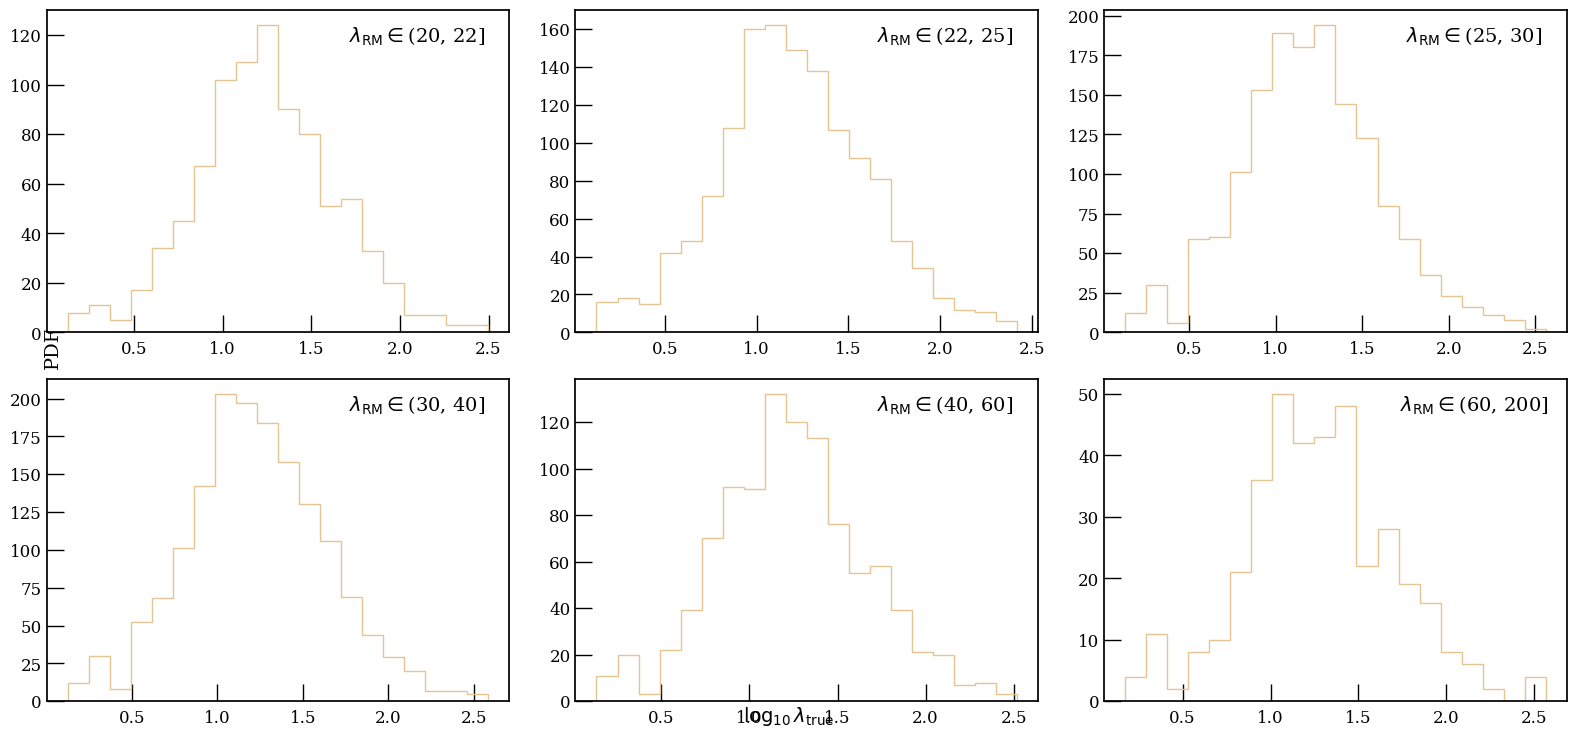

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

fig, ax = plt.subplots(2, 3, figsize=(16, 8))
ax = ax.reshape(-1)
nbins=20
xline = np.linspace(0,2.5, 1000)
fontsize=16

##Todo: Include 1-sigma errors on best_fit

## Plot diagnositc plots for spectroscopic richnesses
cmap = plt.get_cmap('Set2')
ind = 0
for key, group in rm_df.groupby('lmda_bin', observed=True):
    ###Binned data
    y, lmda_binEdges = np.histogram(np.log10(group['lambda_true']), bins=nbins, density=True)
    x = [(lmda_binEdges[i] +lmda_binEdges[i+1])/2 for i in range(len(lmda_binEdges)-1)]
    bin_width = np.asarray([(lmda_binEdges[i+1] - lmda_binEdges[i]) for i in range(len(lmda_binEdges)-1)])
    totNum = len(group)
    numCount = y*bin_width*totNum
    yerr = np.sqrt(numCount)/(bin_width*totNum)
    null_ind = np.where(y==0)[0]
    yerr[null_ind] = 1/(bin_width[null_ind]*totNum)

    ##Plotting
    ax[ind].hist(np.log10(group['lambda_true']), bins=nbins, histtype='step', color=cmap(color_ind), label=str(key))
    text = r'$\lambda_{\rm RM} \in$' + str(key)
    ax[ind].text(0.8, 0.9, text, color='black', transform=ax[ind].transAxes, ha='center')
    ind += 1


##For all
y, lmda_binEdges = np.histogram(np.log10(rm_df['lambda_true']), bins=nbins, density=True)
x = [(lmda_binEdges[i] +lmda_binEdges[i+1])/2 for i in range(len(lmda_binEdges)-1)]
bin_width = np.asarray([(lmda_binEdges[i+1] - lmda_binEdges[i]) for i in range(len(lmda_binEdges)-1)])
totNum = len(rm_df)
numCount = y*bin_width*totNum
yerr = np.sqrt(numCount)/(bin_width*totNum)
null_ind = np.where(y==0)[0]
yerr[null_ind] = 1/(bin_width[null_ind]*totNum)

# Generate random data from a normal distribution
#data = np.random.normal(loc=0, scale=1, size=1000)

# Q-Q plot to compare against the normal distribution
#stats.probplot(data, dist="norm", plot=plt)

# Show the plot
#plt.title("Q-Q Plot against Normal Distribution")
#plt.show()

##Plotting params
#plt.xlabel(r'$\log_{10}{\lambda_{\rm true}}$', fontsize=fontsize)
#plt.ylabel('PDF', fontsize=fontsize)
#plt.legend(loc='best', frameon=False, fontsize=fontsize)
#plt.savefig('lambda_spec_vs_lambda_rm_cpdf.jpeg')
# Add a global x-axis label
fig.text(0.5, 0.04, r'$\log_{10}{\lambda_{\rm true}}$', ha='center', va='center', fontsize=14)
fig.text(0.04, 0.5, 'PDF', ha='center', va='center', rotation='vertical', fontsize=14)
# Adjust the layout to make room for the labels
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import skew, kurtosis

fig, ax = plt.subplots(2, 3, figsize=(20, 12))
ax = ax.reshape(-1)
nbins=20
xline = np.linspace(0,2.5, 1000)
fontsize=16

##Todo: Include 1-sigma errors on best_fit

## Plot diagnositc plots for spectroscopic richnesses
cmap = plt.get_cmap('Set2')
ind = 0
for key, group in rm_df.groupby('lmda_bin', observed=True):
    data = np.log10(group['lambda_true'])
    
    #Generating first, second, third, fourth moments
    logmean = np.mean(data)
    variance = np.var(data)
    skewness = skew(data)
    kurt = kurtosis(data)

    linmean = 10**(logmean + variance/2)

    
    text = r'$\lambda_{\rm RM} \in$ ' + str(key) + '\n' + \
            f"log-mean = {logmean:.2f}" + '\n' + \
            f"linear-mean = {linmean:.2f}" + '\n' + \
            f"variance = {variance:.2f}" + '\n' + \
            f"skewness = {skewness:.2f}" + '\n' + \
            f"kurtosis = {kurt:.2f}"
    
    ax[ind].text(0.1, 0.65, text, color='black', transform=ax[ind].transAxes, ha='left', fontsize=12)
    stats.probplot(np.log10(group['lambda_true']), dist="norm", plot=ax[ind])
    
    ind += 1

# Q-Q plot to compare against the normal distribution
#stats.probplot(data, dist="norm", plot=plt)

# Show the plot
fig.suptitle("Q-Q Plot against Normal Distribution")
#plt.show()

##Plotting params
#plt.xlabel(r'$\log_{10}{\lambda_{\rm true}}$', fontsize=fontsize)
#plt.ylabel('PDF', fontsize=fontsize)
#plt.legend(loc='best', frameon=False, fontsize=fontsize)
#plt.savefig('lambda_spec_vs_lambda_rm_qqplot.jpeg')
plt.show()

### Modeling the lambda_true as a truncated Gaussian

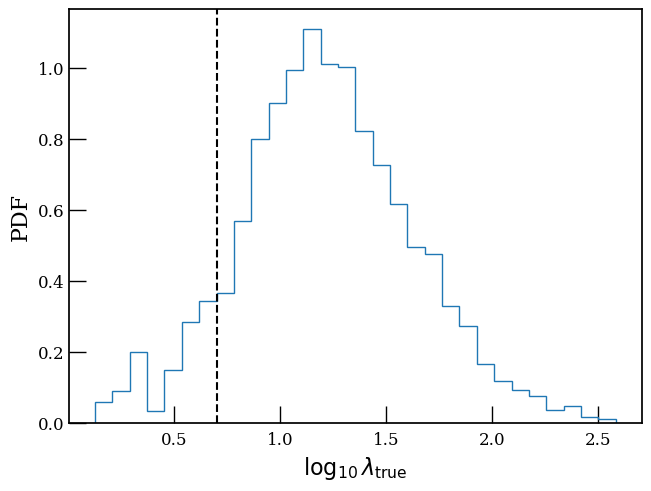

In [17]:
##Histogram 
y, lmda_binEdges = np.histogram(np.log10(rm_df['lambda_true']), bins=30, density=True)
x = [(lmda_binEdges[i] +lmda_binEdges[i+1])/2 for i in range(len(lmda_binEdges)-1)]
bin_width = np.asarray([(lmda_binEdges[i+1] - lmda_binEdges[i]) for i in range(len(lmda_binEdges)-1)])
totNum = len(rm_df)
numCount = y*bin_width*totNum
yerr = np.sqrt(numCount)/(bin_width*totNum)
null_ind = np.where(y==0)[0]
yerr[null_ind] = 1/(bin_width[null_ind]*totNum)

plt.hist(np.log10(rm_df['lambda_true']), bins=30, histtype='step', density=True)

##Plotting params
plt.xlabel(r'$\log_{10}{\lambda_{\rm true}}$', fontsize=fontsize)
plt.ylabel('PDF', fontsize=fontsize)
#plt.legend(loc='best', frameon=False, fontsize=fontsize)
plt.axvline(np.log10(5), color='k', linestyle='--')
#plt.savefig('lambda_spec_vs_lambda_rm_cpdf.jpeg')
plt.show()

In [20]:
# Define the Heaviside function
def heaviside(x):
    return np.where(x >= 0, 1, 0)

def truncated_gaussian_pdf(x, mu, sigma, a=np.log10(5)):
    """
    Calculate the truncated normal PDF at x.

    Parameters:
    x (float or np.array): Points at which to evaluate the PDF.
    mu (float): Mean of the Gaussian distribution.
    sigma (float): Standard deviation of the Gaussian distribution.
    a (float): Lower bound for truncation.

    Returns:
    float or np.array: The value of the truncated normal PDF at x.
    """
    # Standardize the truncation bounds (normalize to standard normal)
    
    lower = (a - mu) / sigma
    #upper = (b - mu) / sigma

    # Calculate the normalization constant (area under the truncated normal)
    norm_const = 1 - stats.norm.cdf(lower)
    #norm_const = stats.norm.cdf(upper) - stats.norm.cdf(lower)

    # Evaluate the normal PDF (standard normal with mean mu and std dev sigma)
    normal_pdf = stats.norm.pdf(x, loc=mu, scale=sigma)*heaviside(x-a)

    # Return the truncated normal PDF
    return normal_pdf / norm_const

def log_prior(theta):
    mu, sigma = theta
    if -10 < mu < 10 and 0.1 < sigma < 10:
        return 0.0  # uniform prior (log(1))
    return -np.inf  # log(0), impossible

def log_likelihood(theta, x, y, yerr):
    mu, sigma = theta
    model = truncated_gaussian_pdf(x, mu, sigma)
    return -0.5 * np.sum(((y - model) / yerr) ** 2)

def log_posterior(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

def run_fit(x, y, yerr, log_posterior, ndim, nwalkers, initial, length=2000, discard=500, verbose=False):
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, yerr))
    sampler.run_mcmc(p0, length, progress=verbose)
    samples = sampler.get_chain(discard=discard, flat=True)
    return sampler, samples

In [21]:
## Cutting the low richness clusters off
cut = np.where(rm_df['lambda_true'] > 5)
rm_df = rm_df.iloc[cut]

100%|██████████| 2000/2000 [00:11<00:00, 171.75it/s]


27.981570626472237 18 0.062336204215139634


100%|██████████| 2000/2000 [00:11<00:00, 173.81it/s]


28.35068006231679 18 0.05691525627786642


100%|██████████| 2000/2000 [00:11<00:00, 173.02it/s]


26.937561843943215 18 0.08017406112255021


100%|██████████| 2000/2000 [00:11<00:00, 174.98it/s]


22.60284319388756 18 0.20631621780140263


100%|██████████| 2000/2000 [00:11<00:00, 174.23it/s]


22.771686789521524 18 0.19951671046766828


100%|██████████| 2000/2000 [00:11<00:00, 170.99it/s]


29.655063378183637 18 0.04093803685534414


100%|██████████| 2000/2000 [00:11<00:00, 170.00it/s]


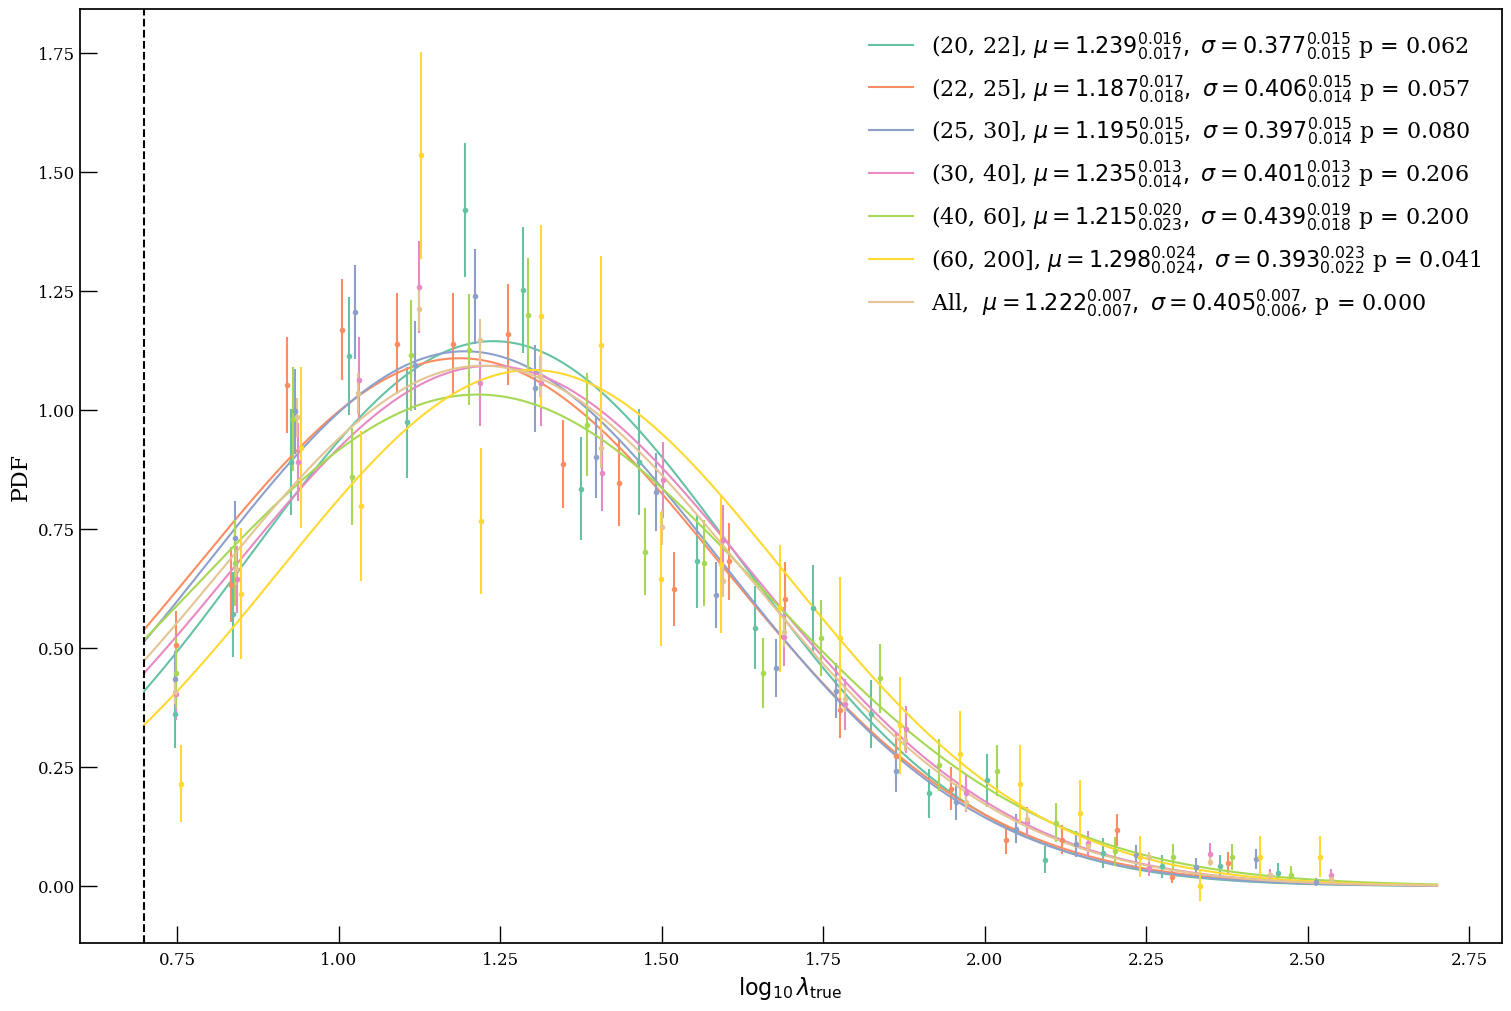

In [22]:
from scipy.stats import chi2
nbins=20
xline = np.linspace(np.log10(5),2.7, 1000)
ndim, nwalkers = 2, 32
initial = np.array([1.1, 0.3])  # Initial guess
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)
length = 2000
discard = 500
verbose=True
fontsize=16
plt.figure(figsize=(15,10))

##Todo: Include 1-sigma errors on best_fit

## Plot diagnositc plots for spectroscopic richnesses
cmap = plt.get_cmap('Set2')
color_ind = 0
for key, group in rm_df.groupby('lmda_bin', observed=True):
    ###Binned data
    y, lmda_binEdges = np.histogram(np.log10(group['lambda_true']), bins=nbins, density=True)
    x = [(lmda_binEdges[i] +lmda_binEdges[i+1])/2 for i in range(len(lmda_binEdges)-1)]
    bin_width = np.asarray([(lmda_binEdges[i+1] - lmda_binEdges[i]) for i in range(len(lmda_binEdges)-1)])
    totNum = len(group)
    numCount = y*bin_width*totNum
    yerr = np.sqrt(numCount)/(bin_width*totNum)
    null_ind = np.where(y==0)[0]
    yerr[null_ind] = 1/(bin_width[null_ind]*totNum)

    ##Include the Gaussian fits here. 
    sampler, samples = run_fit(x, y, yerr, log_posterior, ndim, nwalkers, initial, length=length, discard=discard, verbose=verbose)

    #best_fit = samples[np.argmax(sampler.get_log_prob(flat=True))]
    #best_fit_label = str(key) + r" $\mu = ${:.2f}, $\sigma = ${:.2f}".format(best_fit[1], best_fit[2])

    best_fit = np.percentile(samples, 50, axis=0)
    lower = np.percentile(samples, 16, axis=0)     # Lower 1-sigma
    upper = np.percentile(samples, 84, axis=0)     # Upper 1-sigma
    # 1-sigma errors:
    errs_minus = best_fit - lower
    errs_plus  = upper - best_fit

    ##Chi-squared p-values
    chi_squared = np.sum(((y - truncated_gaussian_pdf(x, *best_fit)) ** 2) / (yerr ** 2))
    dof = len(y) - 2  # For a single parameter model, dof = n - 1
    p_value = 1.0 - chi2.cdf(chi_squared, dof)
    print(chi_squared, dof, p_value)

    best_fit_label = str(key) + \
        r", $\mu = $" + f"${best_fit[0]:.3f}^{{{errs_plus[0]:.3f}}}_{{{errs_minus[0]:.3f}}}, $" +  \
        r" $\sigma = $" + f"${best_fit[1]:.3f}^{{{errs_plus[1]:.3f}}}_{{{errs_minus[1]:.3f}}}$" + \
        r' p = ' + f"{p_value:.3f}"

    ##Plotting
    plt.errorbar(x, y, yerr=yerr, fmt=".", color=cmap(color_ind))
    plt.plot(xline, truncated_gaussian_pdf(xline, *best_fit), label=best_fit_label, color=cmap(color_ind))
    color_ind += 1


##For all
y, lmda_binEdges = np.histogram(np.log10(rm_df['lambda_true']), bins=nbins, density=True)
x = [(lmda_binEdges[i] +lmda_binEdges[i+1])/2 for i in range(len(lmda_binEdges)-1)]
bin_width = np.asarray([(lmda_binEdges[i+1] - lmda_binEdges[i]) for i in range(len(lmda_binEdges)-1)])
totNum = len(rm_df)
numCount = y*bin_width*totNum
yerr = np.sqrt(numCount)/(bin_width*totNum)
null_ind = np.where(y==0)[0]
yerr[null_ind] = 1/(bin_width[null_ind]*totNum)

sampler, samples = run_fit(x, y, yerr, log_posterior, ndim, nwalkers, initial, length=length, discard=discard, verbose=verbose)

#best_fit = samples[np.argmax(sampler.get_log_prob(flat=True))]
best_fit = np.percentile(samples, 50, axis=0)
lower = np.percentile(samples, 16, axis=0)     # Lower 1-sigma
upper = np.percentile(samples, 84, axis=0)     # Upper 1-sigma
# 1-sigma errors:
errs_minus = best_fit - lower
errs_plus  = upper - best_fit
    
##Chi-squared p-values
chi_squared = np.sum(((y - truncated_gaussian_pdf(x, *best_fit)) ** 2) / (yerr ** 2))
# Compute the degrees of freedom (number of data points minus the number of parameters in the model)
dof = len(y) - 2 
# Compute the p-value from the Chi-squared statistic and degrees of freedom
p_value = 1.0 - chi2.cdf(chi_squared, dof)


best_fit_label = "All, " + \
        r" $\mu = $" + f"${best_fit[0]:.3f}^{{{errs_plus[0]:.3f}}}_{{{errs_minus[0]:.3f}}}, $" +  \
        r" $\sigma = $" + f"${best_fit[1]:.3f}^{{{errs_plus[1]:.3f}}}_{{{errs_minus[1]:.3f}}}$" + \
        r', p = ' + f"{p_value:.3f}"


plt.errorbar(x, y, yerr=yerr, fmt=".", color=cmap(color_ind))
plt.plot(xline, truncated_gaussian_pdf(xline, *best_fit), label=best_fit_label, color=cmap(color_ind))
plt.axvline(np.log10(5), color='k', linestyle='--')

##Plotting params
plt.xlabel(r'$\log_{10}{\lambda_{\rm true}}$', fontsize=fontsize)
plt.ylabel('PDF', fontsize=fontsize)
plt.legend(loc='best', frameon=False, fontsize=fontsize)
#plt.savefig('lambda_spec_vs_lambda_rm__truncNorm_cpdf.jpeg')
plt.show()

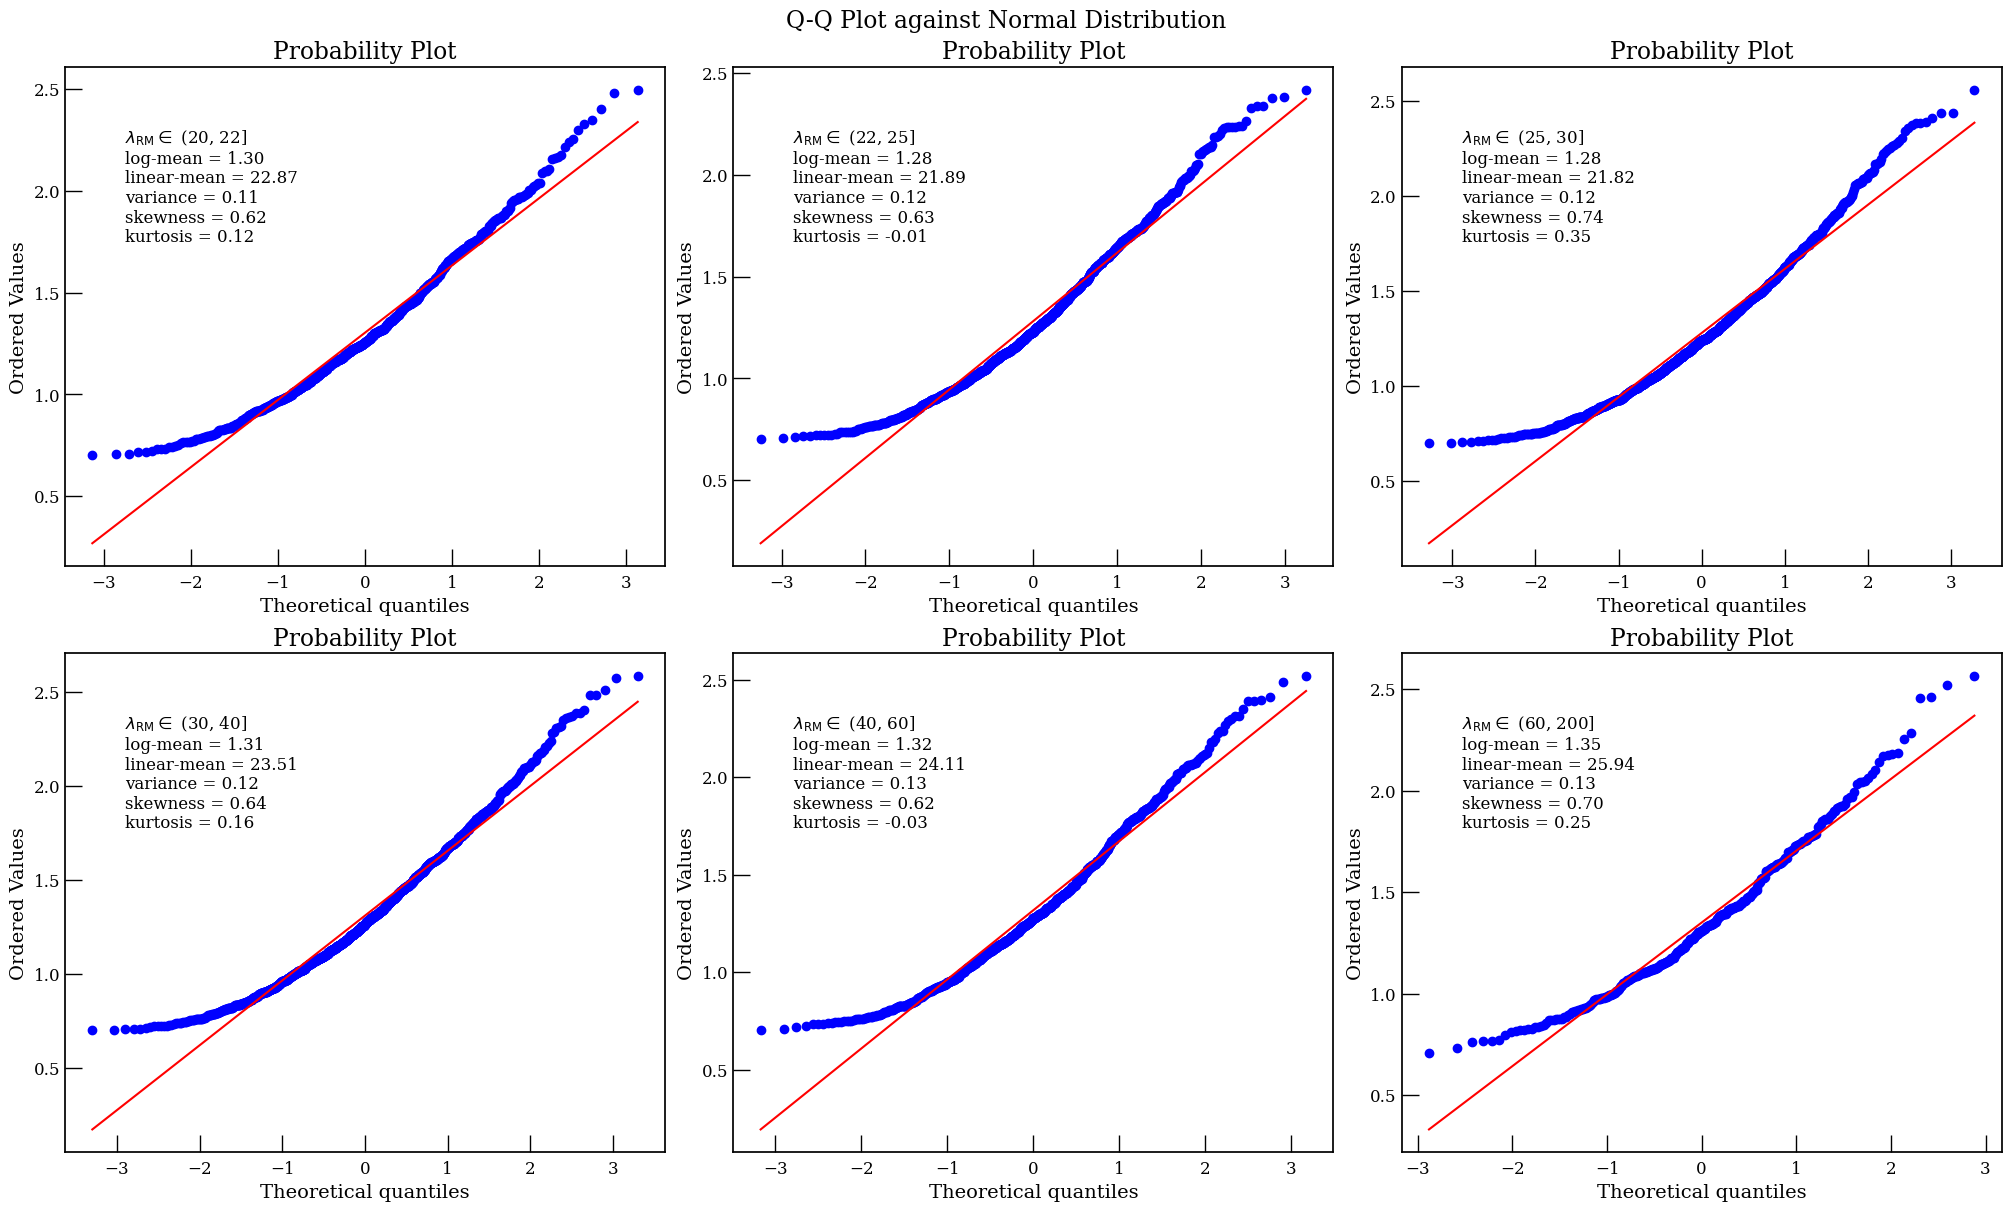

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import skew, kurtosis

fig, ax = plt.subplots(2, 3, figsize=(20, 12))
ax = ax.reshape(-1)
nbins=20
xline = np.linspace(0,2.5, 1000)
fontsize=16

##Todo: Include 1-sigma errors on best_fit

## Plot diagnositc plots for spectroscopic richnesses
cmap = plt.get_cmap('Set2')
ind = 0
for key, group in rm_df.groupby('lmda_bin', observed=True):
    data = np.log10(group['lambda_true'])
    
    #Generating first, second, third, fourth moments
    logmean = np.mean(data)
    variance = np.var(data)
    skewness = skew(data)
    kurt = kurtosis(data)

    linmean = 10**(logmean + variance/2)

    
    text = r'$\lambda_{\rm RM} \in$ ' + str(key) + '\n' + \
            f"log-mean = {logmean:.2f}" + '\n' + \
            f"linear-mean = {linmean:.2f}" + '\n' + \
            f"variance = {variance:.2f}" + '\n' + \
            f"skewness = {skewness:.2f}" + '\n' + \
            f"kurtosis = {kurt:.2f}"
    
    ax[ind].text(0.1, 0.65, text, color='black', transform=ax[ind].transAxes, ha='left', fontsize=12)
    stats.probplot(np.log10(group['lambda_true']), dist="norm", plot=ax[ind])
    
    ind += 1

# Q-Q plot to compare against the normal distribution
#stats.probplot(data, dist="norm", plot=plt)

# Show the plot
fig.suptitle("Q-Q Plot against Normal Distribution")
#plt.show()

##Plotting params
#plt.xlabel(r'$\log_{10}{\lambda_{\rm true}}$', fontsize=fontsize)
#plt.ylabel('PDF', fontsize=fontsize)
#plt.legend(loc='best', frameon=False, fontsize=fontsize)
plt.savefig('lambda_spec_vs_lambda_rm_qqplot.jpeg')
plt.show()

## Do this for binned measurements
* All
* Binned by luminosity
* Redshift
* Outlier removal (sigma-clipping)
* Confidence bands.
* Plot scatter plot compare with Gaussian. 

In [17]:
### Plotting params
smoothing_param = 0
xlim_inset_low = -0.005; xlim_inset_high = 0.005
xlim_low = -0.1; xlim_high = 0.1
ylim_low = 1; ylim_high = 1e4
ylim_inset_low = 10; ylim_inset_high = 1e4
z_anchor = 0.4
shift_wide_val = 0.0002
shift_small_val = 0.0001
fontsize=14
alpha=0.5

In [18]:
import bces.bces as BCES
from scipy.optimize import curve_fit
from scipy.stats.distributions import chi2

# Define your fitting function
def loglinear_function(x, m, c):
    return m * np.log10(x) + c

'''
Fitting using Bivariate Correlated Errors and Intrinsic Scatter (BCES). Need to take into account covariance!
'''
def linear_fit(x, y, xerr, yerr, verbose=False):
    logx = np.log10(lambda_rm_list)
    logy = np.log10(lambda_true_list)
    logxerr = lambda_rm_err_list/(lambda_rm_list*np.log(10))
    logyerr = lambda_true_err_list/(lambda_true_list*np.log(10))
    cov = np.zeros_like(lambda_rm_list)
    #cov = np.ones_like(lambda_rm_list)*np.cov(x,y)[1,0] # Covariance between xerr and yerr (set to zeros if uncorrelated)

    # Perform BCES regression
    a, b, aerr, berr, covab = BCES.bcesp(logx, logxerr, logy, logyerr, cov)
    
    # 'a' and 'b' contain the best-fit parameters (slope and intercept) for different BCES lines.
    # 'aerr' and 'berr' are their respective standard deviations.
    # 'covab' is the covariance between 'a' and 'b'.
    
    # For example, to access the OLS(Y|X) results (index 0):
    slope_ols_yx = a[0]
    intercept_ols_yx = b[0]
    slope_err_ols_yx = aerr[0]
    intercept_err_ols_yx = berr[0]

    if verbose:
        print(f"OLS(Y|X) Slope: {slope_ols_yx:.2f} +/- {slope_err_ols_yx:.2f}")
        print(f"OLS(Y|X) Intercept: {intercept_ols_yx:.2f} +/- {intercept_err_ols_yx:.2f}")

    return  slope_ols_yx, intercept_ols_yx, slope_err_ols_yx, intercept_err_ols_yx

'''
For correlated errors on x and y for linear fit. Need to take into account covariance!
'''
def compute_chisq(x, y, xerr, yerr, slope, intercept, verbose=False):
    # Calculate the effective variance for each point with covariance
    logx = np.log10(lambda_rm_list)
    logy = np.log10(lambda_true_list)
    logxerr = lambda_rm_err_list/(lambda_rm_list*np.log(10))
    logyerr = lambda_true_err_list/(lambda_true_list*np.log(10))
                                   
    df_dlogx_at_x = slope #Derivative at each x_data point 
    df_dx_at_x = 10**intercept *(slope)*x**(slope-1)
    effective_variance = (logyerr**2 + (df_dlogx_at_x * logxerr)**2) #+ np.ones_like(xerr)*2*np.cov(logx,logy)[1,0] #* y * np.log(10) 
    #effective_variance = (yerr**2 + (df_dx_at_x * xerr)**2) #+ np.ones_like(xerr)*2*np.cov(x,y)[1,0]
    
    # Calculate the chi-squared statistic
    #y_fitted = np.log10(10**intercept * x**slope)
    logy_fitted = slope*logx + intercept
    chi_squared = np.sum((logy - logy_fitted)**2 /effective_variance)
    
    # Degrees of freedom (N - number of parameters)
    degrees_of_freedom = len(x) - 2
    p_value = chi2.sf(chi_squared, degrees_of_freedom)

    if verbose:
        print(f"Chi-squared statistic: {chi_squared:.3f}")
        print(f"Degrees of freedom: {degrees_of_freedom}")
        print(f"P-value using sf: {p_value}")
    
    return chi_squared, degrees_of_freedom, p_value

### Apply magnitude cuts

In [19]:
cutDict = {
           'All': {'cut': np.full(len(bgs_matched), True), 'fmt':'h'}, \
           r'$ M_r < -22.5$': {'cut': np.asarray((bgs_matched['M_r'] <-22.5)), 'fmt':'x'}, \
           r'$ M_r < -21.5$': {'cut': np.asarray((bgs_matched['M_r'] <-21.5)), 'fmt':'o'}, 
           r'$ M_r < -20$': {'cut': np.asarray((bgs_matched['M_r'] <-20)), 'fmt':'D'}, 
           r'$ M_r < -19.5$': {'cut': np.asarray((bgs_matched['M_r'] <-19.5)), 'fmt':'*'}, 
           #r'$ -22.5 < M_r < -22$': {'cut': np.asarray((bgs_matched['M_r'] > -22.5) & (bgs_matched['M_r'] < -22)), 'fmt':'o'}, \
           #r'$ -22 < M_r < -21.5$': {'cut': np.asarray((bgs_matched['M_r'] > -22) & (bgs_matched['M_r'] < -21.5)), 'fmt':'D'}, \
           #r'$M_r > -21.5$': {'cut': np.asarray(bgs_matched['M_r']> -21.5), 'fmt':'*'}, \
           #r'$M_r > -20$': {'cut': np.asarray(bgs_matched['M_r'] > -20), 'fmt':'x'} \
          }

In [20]:
bgs_matched = bgs_matched[np.where(bgs_matched['Z_SPEC_x'] > 0.1)]
len(bgs_matched)

81220

IndexError: boolean index did not match indexed array along dimension 0; dimension is 81220 but corresponding boolean dimension is 88423

/global/homes/z/zzhang13/.conda/envs/myEnv_v39/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/global/homes/z/zzhang13/.conda/envs/myEnv_v39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


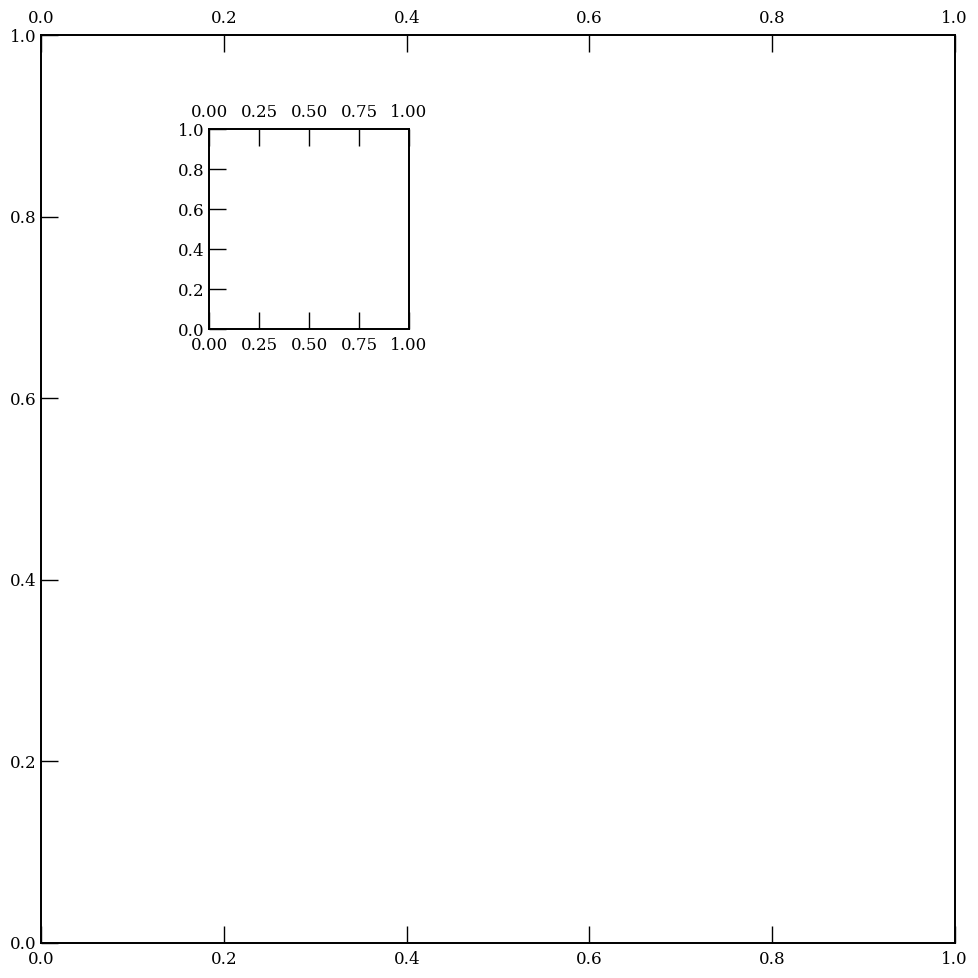

In [21]:
fig, ax1 = plt.subplots(figsize=(10,10), tight_layout=True)
left, bottom, width, height = [0.22, 0.66, 0.2, 0.2]
ax2 = ax1.twiny()
ax3 = fig.add_axes([left, bottom, width, height])
ax4 = ax3.twiny()
shift_small = 0; shift_wide = 0 
for key, val in cutDict.items():
    cut = val['cut']
    fmt = val['fmt']
    curTable = bgs_matched[cut]
    val, y_err = calc_zDiff(binBoundaries, curTable)
    numTotal = len(curTable)
    numCluster = len(np.unique(curTable['ID']))
    val *= numTotal/numCluster
    y_err *= numTotal/numCluster
    x_data = binCent+shift_wide
    
    ##Plotting

    numText = r', $N={:d}$'.format(numCluster)
    ax1.errorbar(x_data, val, yerr=y_err, linestyle='none', label=key+numText,  marker='o', markersize='2')

    
    v_pec = calc_vPec(0, x_data)
    ax2.errorbar(v_pec, val, yerr=y_err, visible=False)


    ##For inset plotting
    val_inset, y_err_inset = calc_zDiff(micro_bin, curTable)
    val_inset *= numTotal/numCluster
    y_err_inset *= numTotal/numCluster
    
    ax3.errorbar(binCent_micro+shift_small, val_inset, yerr=y_err_inset, \
                 linestyle='none', label=key+numText,  marker='o', markersize='2')

    shift_wide += shift_wide_val
    shift_small += shift_small_val

    ##Splining
    y_spl = UnivariateSpline(x_data, val, s=smoothing_param)
    y_err_spl = UnivariateSpline(x_data, y_err, s=smoothing_param)
    y_continuum_prob = calc_Continuum(binBoundaries, binCent, curTable)
    continuum_prob_spl = UnivariateSpline(binCent, y_continuum_prob, s=0)
    continuum_spl = continuum_prob_spl(x_data)*numTotal/numCluster
    y_continuum_removed = (y_spl(x_data)-continuum_spl)
    
    ##Plotting the continuum
    #if key=='All':
    #    ax1.plot(x_data, continuum_spl, label='Continuum', linestyle='dashed', color='blue')
    #   ax1.errorbar(x_data, y_continuum_removed, yerr=y_err, linestyle='none', label='Continuum Removed', marker='D', markersize=3, color='magenta')
    #    ax3.errorbar(x_data, y_continuum_removed, yerr=y_err, marker='D', markersize=3, color='magenta')
        

ax1.legend(loc='best')
ax1.set_yscale('log')
ax1.set_ylim([ylim_low,ylim_high])
#ax1.set_yscale('symlog', linthresh=5)
ax1.set_ylabel(r'$\langle n_{\rm gal} \rangle$', fontsize=fontsize)
ax1.set_xlabel(r"$(z_{\rm{gal}} - z_{\rm{bcg}})/(1+z_{\rm{bcg}})$", fontsize=fontsize)
ax2.set_xlabel(r"$v_{\rm pec}~(km/s)$")
ax1.set_xlim([xlim_low,xlim_high])
ax3.set_xlim([xlim_inset_low,xlim_inset_high])
ax4.set_xlim([calc_vPec(z_anchor, z_anchor+xlim_inset_low),calc_vPec(z_anchor,z_anchor+xlim_inset_high)])
ax3.set_xlabel(r"$(z_{\rm{gal}} - z_{\rm{bcg}})/(1+z_{\rm{bcg}})$")
ax4.set_xlabel(r"$v_{\rm pec}~(km/s)$")
ax3.set_xlabel(r"$(z_{\rm{gal}} - z_{\rm{bcg}})/(1+z_{\rm{bcg}})$")
ax3.set_yscale('log')
#ax3.set_ylim([10,500])
ax3.set_ylabel(r'$\langle n_{\rm gal} \rangle$', fontsize=fontsize)
ax3.set_ylim([ylim_inset_low, ylim_inset_high])
ax3.tick_params(axis='x', labelrotation=30)
plt.savefig('doublePeak_binnedMagnitude.jpeg')
#ax2.set_visible('False')
plt.show()

/global/homes/z/zzhang13/.conda/envs/myEnv_v39/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/global/homes/z/zzhang13/.conda/envs/myEnv_v39/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


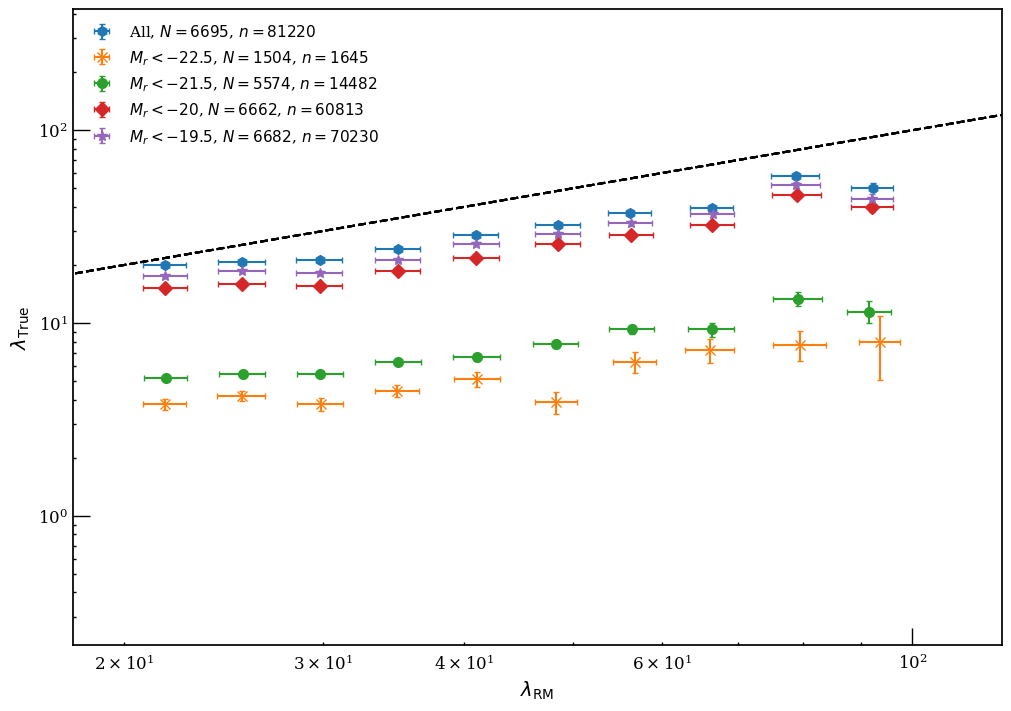

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
xline = np.linspace(0,300,1000)


xshift = 1
for key, val in cutDict.items():
    
    cut = val['cut']
    fmt = val['fmt']
    cutTable = bgs_matched[cut]
    numTotal = len(cutTable)
    numCluster = len(np.unique(cutTable['ID']))

    lambda_true_list = []
    lambda_rm_list = []
    lambda_rm_err_list = []
    lambda_true_err_list = []
    numList = []
    for i, lmda_bin in enumerate(lmda_bins):
        #for j, z_bin in enumerate(z_bins):
            #cut &=(bgs_matched['Z_SPEC_x'] >= z_bin[0]) & (bgs_matched['Z_SPEC_x'] < z_bin[1])
            ##Apply binning
        cut = (cutTable['LAMBDA'] >= lmda_bin[0]) & (cutTable['LAMBDA'] < lmda_bin[1])
            
        binnedTable = cutTable[cut]
        lambda_tot, lambda_true, lambda_true_err = calc_specRichness_stacked(binBoundaries, binCent, binnedTable)
        lambda_rm_list = np.hstack((lambda_rm_list, np.mean(binnedTable['LAMBDA'])))  
        lambda_rm_err_list = np.hstack((lambda_rm_err_list, np.std(binnedTable['LAMBDA'])))  
        lambda_true_err_list = np.hstack((lambda_true_err_list, lambda_true_err))  
        lambda_true_list = np.hstack((lambda_true_list,lambda_true))   
        numList = np.hstack((numList,len(unique(binnedTable, keys='ID'))))

    label = key + ', ' + r'$N={:d}$'.format(numCluster) + r', $n={:d}$'.format(numTotal)
    ax.errorbar(lambda_rm_list*xshift, lambda_true_list, yerr = lambda_true_err_list, xerr = lambda_rm_err_list, \
                linestyle='none', label=label, fmt=fmt, capsize=2, ms=7)
    ax.plot(xline,xline,color='black', linestyle='dashed')
    #xshift *=1.02

    
ax.set_xlabel(r'$\lambda_{\rm RM}$')

ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([20,30,50,70,100,150])
ax.set_yticks([5,10,20,30,50,100,300])
ax.set_ylabel(r'$\lambda_{\rm True}$')
ax.set_xscale('log'); 
ax.set_yscale('log')
ax.set_xlim([18,120]); 
#ax.set_ylim([10,100])
plt.legend(frameon=False, loc='best')
plt.savefig('specrichness_vs_rmrichness_binnedMagnitude.jpeg')
plt.show()

In [ ]:
## Error estimation on the noise 

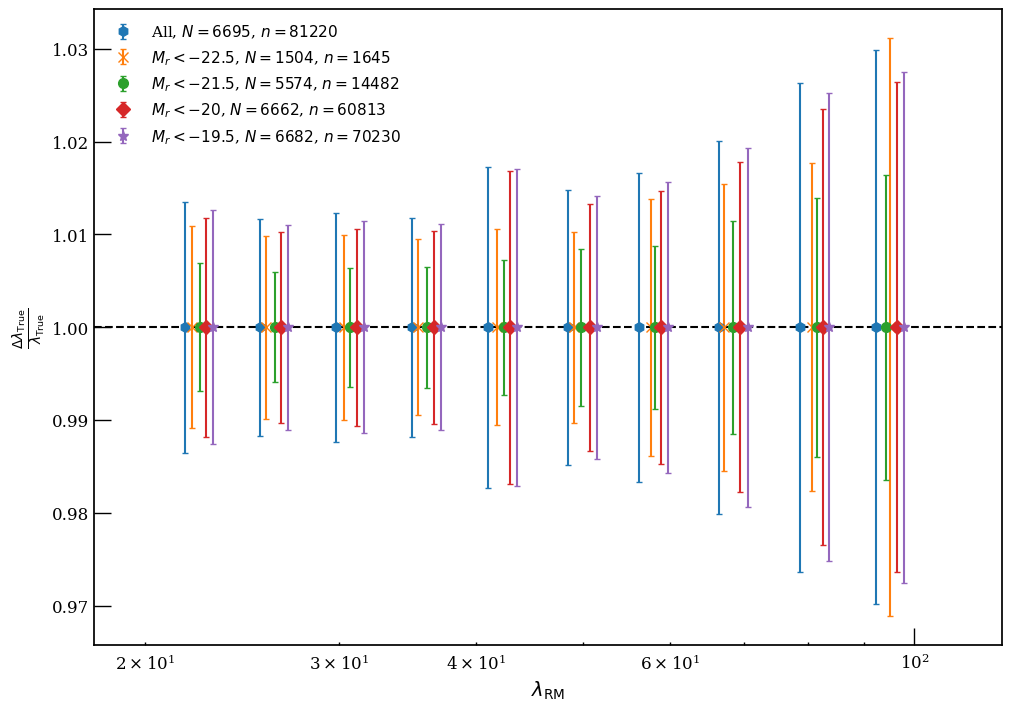

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
xline = np.linspace(0,300,1000)

xshift = 1
for key, val in cutDict.items():
    
    cut = val['cut']
    fmt = val['fmt']
    cutTable = bgs_matched[cut]
    numTotal = len(cutTable)
    numCluster = len(np.unique(cutTable['ID']))

    lambda_true_list = []
    lambda_rm_list = []
    lambda_rm_err_list = []
    lambda_true_err_list = []
    numList = []
    for i, lmda_bin in enumerate(lmda_bins):
        #for j, z_bin in enumerate(z_bins):
            #cut &=(bgs_matched['Z_SPEC_x'] >= z_bin[0]) & (bgs_matched['Z_SPEC_x'] < z_bin[1])
            ##Apply binning
        cut = (cutTable['LAMBDA'] >= lmda_bin[0]) & (cutTable['LAMBDA'] < lmda_bin[1])
            
        binnedTable = cutTable[cut]
        lambda_tot, lambda_true, lambda_true_err = calc_specRichness_stacked(binBoundaries, binCent, binnedTable)
        lambda_rm_list = np.hstack((lambda_rm_list, np.mean(binnedTable['LAMBDA'])))  
        lambda_rm_err_list = np.hstack((lambda_rm_err_list, np.std(binnedTable['LAMBDA'])))  
        lambda_true_err_list = np.hstack((lambda_true_err_list, lambda_true_err))  
        lambda_true_list = np.hstack((lambda_true_list,lambda_true))   
        numList = np.hstack((numList,len(unique(binnedTable, keys='ID'))))

    label = key + ', ' + r'$N={:d}$'.format(numCluster) + r', $n={:d}$'.format(numTotal)
    ax.errorbar(lambda_rm_list*xshift, np.ones_like(lambda_rm_list), yerr = lambda_true_err_list/lambda_rm_list, \
                linestyle='none', label=label, fmt=fmt, capsize=2, ms=7)
    #ax.plot(xline, xline,color='black', linestyle='dashed')
    xshift *=1.015

    
ax.set_xlabel(r'$\lambda_{\rm RM}$')

ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([20,30,50,70,100,150])
#ax.set_yticks([5,10,20,30,50,100,300])
ax.set_ylabel(r'$\frac{\Delta\lambda_{\rm True}}{\lambda_{\rm True}}$')
ax.set_xscale('log'); 
#ax.set_yscale('log')
ax.set_xlim([18,120]); 
#ax.set_ylim([10,100])
plt.axhline(1, linestyle='dashed', color='black')
plt.legend(frameon=False, loc='best')
#plt.savefig('specrichness_vs_rmrichness_binnedMagnitude.jpeg')
plt.show()

## Redshift Cuts

In [ ]:
cutDict = {
           'All': {'cut': np.full(len(bgs_matched), True), 'fmt':'h'}, \
           r'$z \in [0.15,0.25)$': {'cut': np.asarray((bgs_matched['Z_SPEC_x'] >= 0.15) & (bgs_matched['Z_SPEC_x'] < 0.25)), 'fmt':'o'}, \
           r'$z \in [0.25,0.40)$': {'cut': np.asarray((bgs_matched['Z_BGS'] > 0.25) & (bgs_matched['Z_BGS'] < 0.40)), 'fmt':'x'}, \
           #r'$z \in [0.30,0.40)$': {'cut': np.asarray((bgs_matched['Z_SPEC_x'] >= 0.30) & (bgs_matched['Z_SPEC_x'] < 0.40)), 'fmt':'D'}, \
           #r'$z \in [0.30,0.40)$': {'cut': np.asarray((bgs_matched['Z_BGS'] > 0.30) & (bgs_matched['Z_BGS'] < 0.40)), 'fmt':'s'}, \
          }

/tmp/ipykernel_1438302/756938506.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('doublePeak_binnedRedshift.jpeg')
/tmp/ipykernel_1438302/756938506.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('doublePeak_binnedRedshift.jpeg')
/global/homes/z/zzhang13/.conda/envs/myEnv_v39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


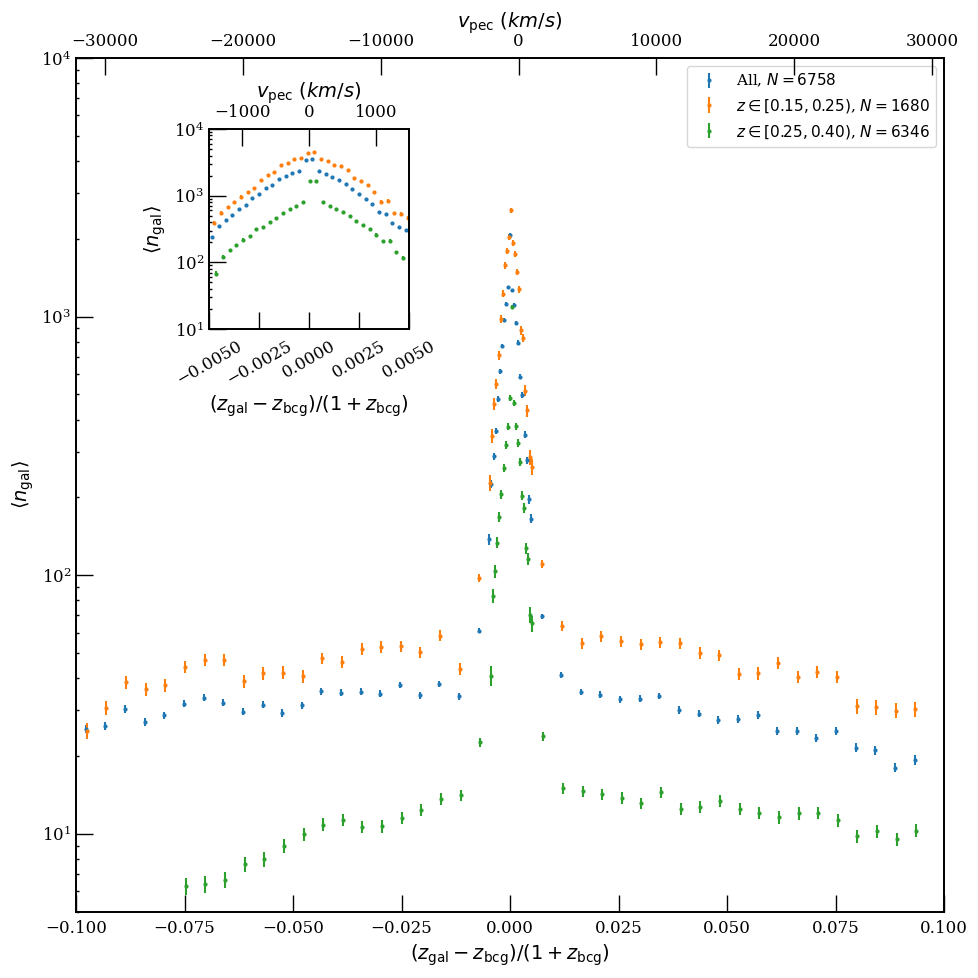

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,10), tight_layout=True)
left, bottom, width, height = [0.22, 0.66, 0.2, 0.2]
ax2 = ax1.twiny()
ax3 = fig.add_axes([left, bottom, width, height])
ax4 = ax3.twiny()
shift_small = 0; shift_wide = 0 

for key, val in cutDict.items():
    cut = val['cut']
    fmt = val['fmt']
    curTable = bgs_matched[cut]
    val, y_err = calc_zDiff(binBoundaries, curTable)
    numTotal = len(curTable)
    numCluster = len(np.unique(curTable['ID']))
    val *= numTotal/numCluster
    y_err *= numTotal/numCluster
    x_data = binCent+shift_wide
    
    ##Plotting

    numText = r', $N={:d}$'.format(numCluster)
    ax1.errorbar(x_data, val, yerr=y_err, linestyle='none', label=key+numText,  marker='o', markersize='2')

    v_pec = calc_vPec(0, x_data)
    ax2.errorbar(v_pec, val, yerr=y_err, visible=False)


    ##For inset plotting
    val_inset, y_err_inset = calc_zDiff(micro_bin, curTable)
    val_inset *= numTotal/numCluster
    y_err_inset *= numTotal/numCluster
    
    ax3.errorbar(binCent_micro+shift_small, val_inset, yerr=y_err_inset, \
                 linestyle='none', label=key+numText,  marker='o', markersize='2')

    shift_wide += shift_wide_val
    shift_small += shift_small_val

    ##Splining
    y_spl = UnivariateSpline(x_data, val, s=smoothing_param)
    y_err_spl = UnivariateSpline(x_data, y_err, s=smoothing_param)
    y_continuum_prob = calc_Continuum(binBoundaries, binCent, curTable)
    continuum_prob_spl = UnivariateSpline(binCent, y_continuum_prob, s=0)
    continuum_spl = continuum_prob_spl(x_data)*numTotal/numCluster
    y_continuum_removed = (y_spl(x_data)-continuum_spl)
    
    ##Plotting the continuum
    #if key=='All':
    #    ax1.plot(x_data, continuum_spl, label='Continuum', linestyle='dashed', color='blue')
    #   ax1.errorbar(x_data, y_continuum_removed, yerr=y_err, linestyle='none', label='Continuum Removed', marker='D', markersize=3, color='magenta')
    #    ax3.errorbar(x_data, y_continuum_removed, yerr=y_err, marker='D', markersize=3, color='magenta')
        

ax1.legend(loc='best')
ax1.set_yscale('log')
ax1.set_ylim([ylim_low,ylim_high])
#ax1.set_yscale('symlog', linthresh=5)
ax1.set_ylabel(r'$\langle n_{\rm gal} \rangle$', fontsize=fontsize)
ax1.set_xlabel(r"$(z_{\rm{gal}} - z_{\rm{bcg}})/(1+z_{\rm{bcg}})$", fontsize=fontsize)
ax2.set_xlabel(r"$v_{\rm pec}~(km/s)$")
ax1.set_xlim([xlim_low,xlim_high])
ax3.set_xlim([xlim_inset_low,xlim_inset_high])
ax4.set_xlim([calc_vPec(z_anchor, z_anchor+xlim_inset_low),calc_vPec(z_anchor,z_anchor+xlim_inset_high)])
ax3.set_xlabel(r"$(z_{\rm{gal}} - z_{\rm{bcg}})/(1+z_{\rm{bcg}})$")
ax4.set_xlabel(r"$v_{\rm pec}~(km/s)$")
ax3.set_xlabel(r"$(z_{\rm{gal}} - z_{\rm{bcg}})/(1+z_{\rm{bcg}})$")
ax3.set_yscale('log')
#ax3.set_ylim([10,500])
ax3.set_ylabel(r'$\langle n_{\rm gal} \rangle$', fontsize=fontsize)
ax3.set_ylim([ylim_inset_low, ylim_inset_high])
ax3.tick_params(axis='x', labelrotation=30)
plt.savefig('doublePeak_binnedRedshift.jpeg')
#ax2.set_visible('False')
plt.show()

In [ ]:
from cycler import cycler

fig, ax = plt.subplots(figsize=(10,10))
xline = np.linspace(0,300,1000)
# Choose a colormap
cc = (cycler(color=['c', 'm', 'y']) *
      cycler(linestyle=['none', '--']))
ax.set_prop_cycle(cc)

xshift = 1
for key, val in cutDict.items():
    
    cut = val['cut']
    fmt = val['fmt']
    cutTable = bgs_matched[cut]
    numTotal = len(cutTable)
    numCluster = len(np.unique(cutTable['ID']))

    lambda_true_list = []
    lambda_rm_list = []
    lambda_rm_err_list = []
    lambda_true_err_list = []
    numList = []
    for i, lmda_bin in enumerate(lmda_bins):
        #for j, z_bin in enumerate(z_bins):
            #cut &=(bgs_matched['Z_SPEC_x'] >= z_bin[0]) & (bgs_matched['Z_SPEC_x'] < z_bin[1])
            ##Apply binning
        cut = (cutTable['LAMBDA'] >= lmda_bin[0]) & (cutTable['LAMBDA'] < lmda_bin[1])
        
        binnedTable = cutTable[cut]
        #assert(len(binnedTable) > 1), "Not enough galaxies in bin."
        lambda_tot, lambda_true, lambda_true_err = calc_specRichness_stacked(binBoundaries, binCent, binnedTable)
        lambda_rm_list = np.hstack((lambda_rm_list, np.mean(binnedTable['LAMBDA'])))  
        lambda_rm_err_list = np.hstack((lambda_rm_err_list, np.std(binnedTable['LAMBDA'])))  
        lambda_true_err_list = np.hstack((lambda_true_err_list, lambda_true_err))  
        lambda_true_list = np.hstack((lambda_true_list,lambda_true))   
        numList = np.hstack((numList,len(unique(binnedTable, keys='ID'))))

    
    ##Linear fitting
    slope, intercept, slope_err, intercept_err = linear_fit(lambda_rm_list, lambda_true_list, lambda_rm_err_list, lambda_true_err_list)
    chi_squared, degrees_of_freedom, p_value = compute_chisq(lambda_rm_list, lambda_true_list, lambda_rm_err_list, lambda_true_err_list, slope, intercept, verbose=True)
    y_fitted = 10**intercept * lambda_rm_list**slope

    best_fit_label = r'$\log(y)={:.2f}(\pm {:.2f})\log(x) {:+.2f}(\pm {:.2f}), p={:.3f}$'.format(slope, slope_err, intercept, intercept_err, p_value)
    label = key + ', ' + r'$N={:d}$'.format(numCluster) + ', ' + best_fit_label
    
    ax.errorbar(lambda_rm_list*xshift, lambda_true_list, yerr = lambda_true_err_list, xerr = lambda_rm_err_list, \
                linestyle='none', label=label, fmt=fmt, capsize=2, ms=7)
    
    #xshift *=1.02
    ax.plot(lambda_rm_list, y_fitted)


ax.plot(xline,xline,color='black', linestyle='dashed')    
ax.set_xlabel(r'$\lambda_{\rm RM}$')
ax.set_ylabel(r'$\lambda_{\rm True}$')
ax.set_xlim([18,100]); ax.set_ylim([5,200])
ax.set_xticks([20,30,50,70,100])
ax.set_yticks([5,10,20,30,50,100])
ax.set_xscale('log'); 
ax.set_yscale('log')
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.legend(frameon=False, loc='best')
plt.savefig('specrichness_vs_rmrichness_binnedRedshift.jpeg')
plt.show()

/global/homes/z/zzhang13/.conda/envs/myEnv_v39/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/global/homes/z/zzhang13/.conda/envs/myEnv_v39/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


BCES, 10000 trials... 
1.299279 s
Chi-squared statistic: 37.461
Degrees of freedom: 8
P-value using sf: 9.46453362638894e-06
BCES, 10000 trials... 
1.296027 s
Chi-squared statistic: 19.112
Degrees of freedom: 8
P-value using sf: 0.014273872710096766
BCES, 10000 trials... 
1.244699 s
Chi-squared statistic: 22.900
Degrees of freedom: 8
P-value using sf: 0.0034955098624276123


## Fitting the data

### BCES 

For computing linear regression when x and y have correlated errors

In [ ]:
lambda_true_list = []
lambda_rm_list = []
lambda_rm_err_list = []
lambda_true_err_list = []
numList = []
for i, lmda_bin in enumerate(lmda_bins):
        #for j, z_bin in enumerate(z_bins):
            #cut &=(bgs_matched['Z_SPEC_x'] >= z_bin[0]) & (bgs_matched['Z_SPEC_x'] < z_bin[1])
            ##Apply binning
    cut = (cutTable['LAMBDA'] >= lmda_bin[0]) & (cutTable['LAMBDA'] < lmda_bin[1])
            
    binnedTable = cutTable[cut]
    lambda_tot, lambda_true, lambda_true_err = calc_specRichness_stacked(binBoundaries, binCent, binnedTable)
    lambda_rm_list = np.hstack((lambda_rm_list, np.mean(binnedTable['LAMBDA'])))  
    lambda_rm_err_list = np.hstack((lambda_rm_err_list, np.std(binnedTable['LAMBDA'])))  
    lambda_true_err_list = np.hstack((lambda_true_err_list, lambda_true_err))  
    lambda_true_list = np.hstack((lambda_true_list,lambda_true))   
    numList = np.hstack((numList,len(unique(binnedTable, keys='ID'))))

/global/homes/z/zzhang13/.conda/envs/myEnv_v39/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/global/homes/z/zzhang13/.conda/envs/myEnv_v39/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


In [ ]:
x = lambda_rm_list
xerr = lambda_rm_err_list
y = lambda_true_list
yerr = lambda_true_err_list

logx= np.log10(x)
logy= np.log10(y)
logxerr = xerr/(x*np.log(10))
logyerr = yerr/(y*np.log(10))    

In [ ]:
a, b, aerr, berr, covab = BCES.bcesp(logx, logxerr, logy,  logyerr, np.zeros_like(lambda_rm_list))

BCES, 10000 trials... 
1.503200 s


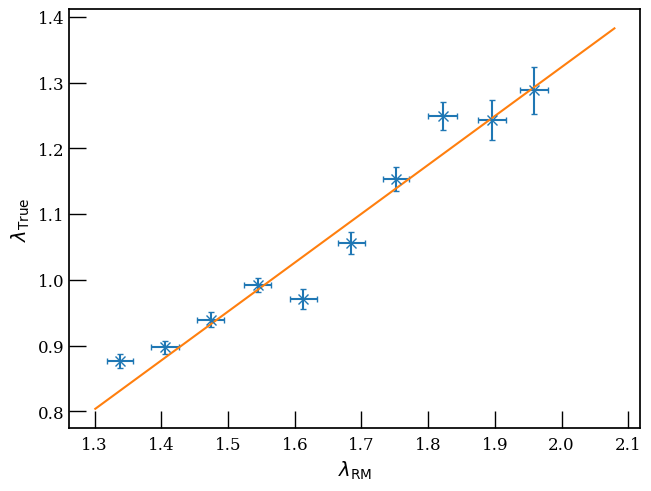

In [ ]:
fig, ax = plt.subplots()
logxline = np.linspace(np.log10(20),np.log10(120),200)
logy_fitted = a[0]*logxline + b[0]

plt.errorbar(logx, logy, xerr = logxerr, yerr = logyerr, \
                linestyle='none', label=label, fmt=fmt, capsize=2, ms=7)
plt.plot(logxline, logy_fitted)
ax.set_xlabel(r'$\lambda_{\rm RM}$')
ax.set_ylabel(r'$\lambda_{\rm True}$')

#ax.set_xticks([20,30,50,70,100,150])
#ax.set_yticks([5,10,20,30,50,100])
#ax.set_xlim([18,200]); ax.set_ylim([1,200])
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#plt.legend(frameon=False, loc='best')
plt.show()

In [ ]:
slope=a[0]
intercept=b[0]
df_dlogx_at_x = slope #Derivative at each x_data point 
effective_variance = (logyerr**2 + (df_dlogx_at_x * logxerr)**2) #+ np.ones_like(xerr)*2*np.cov(logx,logy)[1,0] #* y * np.log(10) 
    
# Calculate the chi-squared statistic
logy_fitted = slope*logx + intercept
chi_squared = np.sum((logy - logy_fitted)**2 /effective_variance)
    
# Degrees of freedom (N - number of parameters)
degrees_of_freedom = len(x) - 2
p_value = chi2.sf(chi_squared, degrees_of_freedom)

print(f"Chi-squared statistic: {chi_squared:.3f}")
print(f"Degrees of freedom: {degrees_of_freedom}")
print(f"P-value using sf: {p_value}")

Chi-squared statistic: 23.878
Degrees of freedom: 8
P-value using sf: 0.00240265532765074


In [ ]:
a, b, aerr, berr, covab = BCES.bcesp(logx, logxerr, logy,  logyerr, np.zeros_like(lambda_rm_list))

BCES, 10000 trials... 
1.657421 s


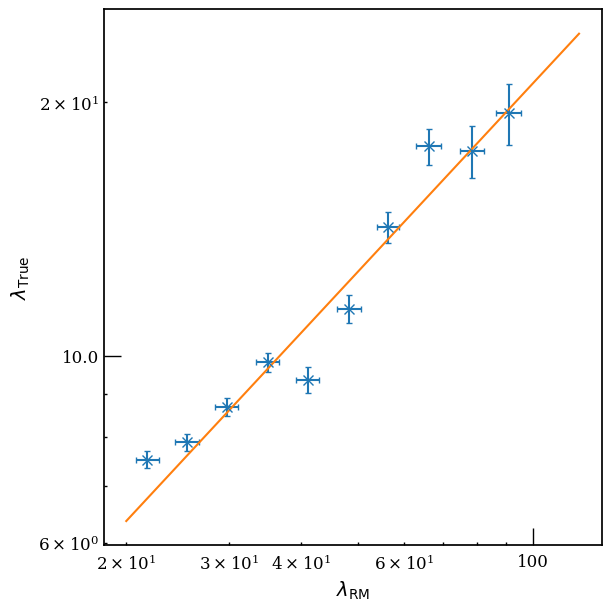

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
logxline = np.linspace(np.log10(20),np.log10(120),200)
y_fitted = 10**(logxline*a[0] + b[0])

plt.errorbar(x, y, xerr = xerr, yerr = yerr, \
                linestyle='none', label=label, fmt=fmt, capsize=2, ms=7)
plt.plot(10**logxline, y_fitted)
ax.set_xlabel(r'$\lambda_{\rm RM}$')
ax.set_ylabel(r'$\lambda_{\rm True}$')

ax.set_xticks([20,30,50,70,100,150])
ax.set_yticks([5,10,20,30,50,100])
#ax.set_xlim([18,200]); ax.set_ylim([1,200])
ax.set_xscale('log')
ax.set_yscale('log')
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#plt.legend(frameon=False, loc='best')
plt.show()

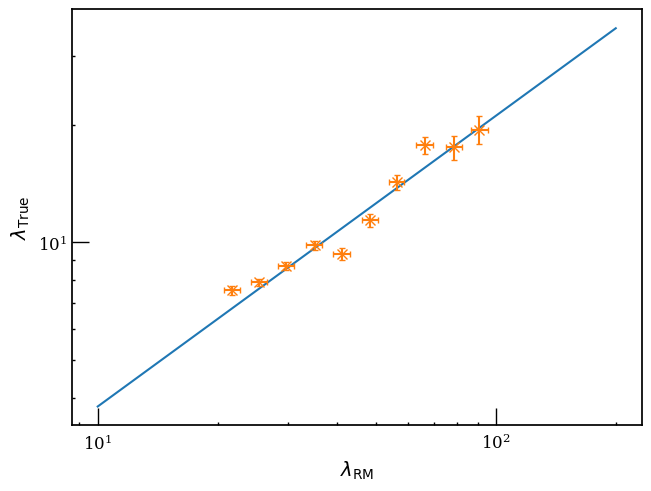

In [ ]:
fig, ax = plt.subplots()
xline = np.linspace(10,200,200)
y_fitted = 10**(np.log10(xline)*slope +intercept)
#y_fitted = linear_function(xline, a[0], b[0])
plt.plot(xline, y_fitted)
plt.errorbar(lambda_rm_list, lambda_true_list, yerr = lambda_true_err_list, xerr = lambda_rm_err_list, \
                linestyle='none', label=label, fmt=fmt, capsize=2, ms=7)
ax.set_xlabel(r'$\lambda_{\rm RM}$')
ax.set_ylabel(r'$\lambda_{\rm True}$')
ax.set_xscale('log'); 
ax.set_yscale('log')
plt.show()

In [ ]:
plt.plot(lambda_rm_list, lambda_rm_err_list, label='RM error')
plt.plot(lambda_rm_list, lambda_true_err_list, label='Spec error')
plt.legend()
plt.xlabel('RM richness')
plt.show()

## Diagnosing this plot

* We ought to find that most (if not all) RM clusters should be inside 

In [ ]:
plt.scatter(bgs_matched['M_r'], 1/bgs_matched['WEIGHT'])
plt.ylabel('1/WEIGHT')
plt.xlabel('M_r')
plt.show()

In [ ]:
table = bgs_matched
z_diff = (table['Z_BGS']-table['Z_SPEC_x'])/(1+table['Z_BGS'])
val, bin_edges= np.histogram(z_diff, bins=binBoundaries, density=True)


In [ ]:
bgs_groupedbyRM = bgs_matched.group_by('ID')
mask = bgs_groupedbyRM.groups.keys['ID'] == 476 
print(bgs_groupedbyRM.groups[mask])

In [ ]:
table = bgs_groupedbyRM.groups[mask]

In [ ]:
z_diff = (table['Z_BGS']-table['Z_SPEC_x'])/(1+table['Z_BGS'])
print(z_diff)
print(table['WEIGHT'])
print("geoFrac= ",table['geoFrac'][0])
print(table['LAMBDA'][0])
val, bin_edges= np.histogram(z_diff, bins=binBoundaries, density=True)

In [ ]:
totNum = len(z_diff)
x, weights_all = calc_weights_all(binBoundaries, table)
bin_width = np.asarray([binBoundaries[i+1]-binBoundaries[i] for i in range(len(binBoundaries[:-1]))])
lambda_tot = np.sum(val*bin_width*weights_all)*totNum 
print(lambda_tot)

In [ ]:
bgs_groupedbyRM = bgs_matched.group_by('ID')
ID_list = []
lambda_true_list = []
lambda_tot_list = []
for key, group in zip(bgs_groupedbyRM.groups.keys, bgs_groupedbyRM.groups):    
        pdf, y_err = calc_zDiff(binBoundaries, group, numCount_bool=False)
        ## Remove histograms with np.nan
        if np.any(np.isnan(pdf)):
            print(key, " Is NAN")
            continue
        totNum = len(group)